<H1 style="background-color:LightCoral;">
    <center>
         Kaggle
     </center>
 </H1>

https://www.kaggle.com/datasets/mariafrenti/age-prediction

<H1 style="background-color:LightCoral;">
    <center>
         Imports
     </center>
 </H1>

In [1]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo


import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


/home/amitli/OrYair/orYairVenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<H1 style="background-color:LightCoral;">
    <center>
         Load Data
     </center>
 </H1>

In [3]:
TRAIN_FOLDER = "/home/amitli/Datasets/Age prediction/20-50/train"
TEST_FOLDER  = "/home/amitli/Datasets/Age prediction/20-50/test"


 #-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    #transforms.Resize    (224),
    #transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])


batchSize            = 32
oDataSet             = ImageFolder(root=TRAIN_FOLDER, transform=oTransforms)
oTrainSet, oTestSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * len(oDataSet), 0.1 * len(oDataSet)]).astype(int))

oTrainSet.transform  = oTransforms
oTestSet .transform  = oTransforms

oTrainDL  = torch.utils.data.DataLoader(oTrainSet,   batch_size=batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,    batch_size=batchSize, num_workers=2, persistent_workers=True)

<H1 style="background-color:LightCoral;">
    <center>
         EDA
     </center>
 </H1>

In [4]:
x, y = next(iter(oTrainDL))
print (x[0].shape)

torch.Size([3, 128, 128])


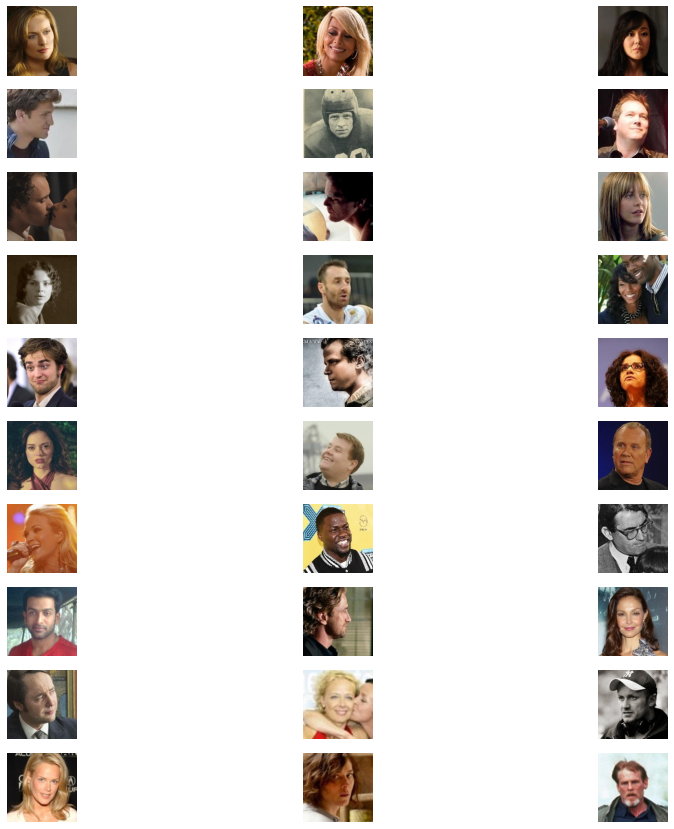

<Figure size 1152x1152 with 0 Axes>

In [6]:
f, axarr = plt.subplots(10,3,figsize=(15,15))

from matplotlib.pyplot import figure
figure(figsize=(16, 16))

for catgory in range(0,3):
    for age in range (20, 30):
       
        image_age = age + 10*catgory       
        img_path  = f"{TRAIN_FOLDER}/{image_age}/"
        img_file  = random.choice(os.listdir(img_path))
        img_fp    = f"{img_path}/{img_file}"
        img       = mpimg.imread(img_fp)       
        axarr[age-20,catgory].imshow(img)
        axarr[age-20,catgory].axis('off')



<H1 style="background-color:LightCoral;">
    <center>
         Prepare GPU
     </center>
 </H1>

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cuda:0


<H1 style="background-color:LightCoral;">
    <center>
         Basic CNN model
     </center>
 </H1>

In [5]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False),           nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False),           nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(64,  128, 3, bias=False),           nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(128, 256, 3, bias=False, stride=2), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (256, 31),
    )
    
    return oModel

torchinfo.summary(GetModel(), (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [32, 3, 128, 128]         --
├─Conv2d: 1-2                            [32, 16, 126, 126]        432
├─BatchNorm2d: 1-3                       [32, 16, 126, 126]        32
├─ReLU: 1-4                              [32, 16, 126, 126]        --
├─Dropout2d: 1-5                         [32, 16, 126, 126]        --
├─Conv2d: 1-6                            [32, 32, 124, 124]        4,608
├─BatchNorm2d: 1-7                       [32, 32, 124, 124]        64
├─ReLU: 1-8                              [32, 32, 124, 124]        --
├─Dropout2d: 1-9                         [32, 32, 124, 124]        --
├─Conv2d: 1-10                           [32, 64, 61, 61]          18,432
├─BatchNorm2d: 1-11                      [32, 64, 61, 61]          128
├─ReLU: 1-12                             [32, 64, 61, 61]          --
├─Drop

<H1 style="background-color:LightCoral;">
    <center>
         Train and Epoc codes
     </center>
 </H1>

In [7]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [8]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [9]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

<H1 style="background-color:LightCoral;">
    <center>
         Train 
     </center>
 </H1>

In [ ]:
nEpochs    = 20
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
Metric     = Accuracy
oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='Classification-CNN')

<H1 style="background-color:LightCoral;">
    <center>
         Predict
     </center>
 </H1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

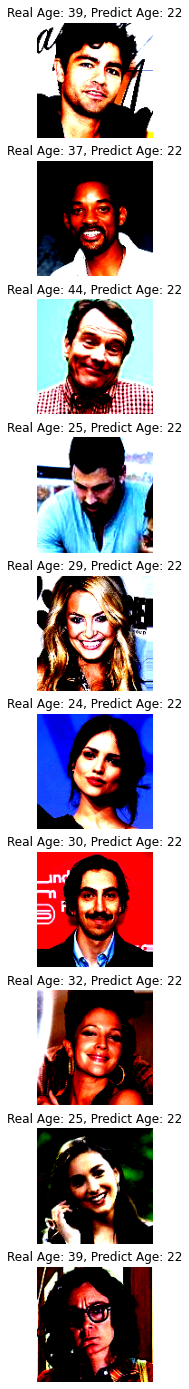

In [6]:
oModel = GetModel     ().to(DEVICE)
oModel.load_state_dict(torch.load('Classification-CNN.pt'))
oModel.train(False) 

mX, vY = next(iter(oTestDL))
mX     = mX.to(DEVICE)
hatY   = oModel(mX)

#hatY = hatY.squeeze().cpu().detach().numpy()
y    = vY.cpu().numpy()

f, axarr = plt.subplots(10,1,figsize=(25,25))


for i in range(len(y)):   
   
    # get predicted label (with max probablilty) 
    vProb  = torch.softmax(hatY, dim=0)
    idx    = torch.argmax (hatY)
    idx    = idx.cpu().numpy()
    
    
    real_age    = y[i] + 20         # +20 because ImageFolder starts from 0
    predict_age = idx  + 20
    
    
    axarr[i].set_title(f"Real Age: {real_age}, Predict Age: {int(predict_age)}")
    img = mX[i].cpu()   
    img = img.permute(1,2,0).numpy()  
    img = img# *vMean+vStd    
    
    axarr[i].imshow(img)
    axarr[i].axis('off')
    
    if i == 9:
        break

    

<H1 style="background-color:LightCoral;">
    <center>
         SHAP
     </center>
 </H1>

According to:
https://github.com/slundberg/shap/issues/1479
There is bug with resnet50 and shap because resnet50 reuse same relu layer (instead of 2 serpate instances)

In [7]:
import shap
shap.initjs()

<H1 style="background-color:LightCoral;">
    <center>
         WE CAN USE GPU (I have only 4GB, so I run on CPU)
     </center>
 </H1>

In [15]:
DEVICE = torch.device('cpu')
oModel = GetModel     ().to(DEVICE)
oModel.load_state_dict(torch.load('Classification-CNN.pt'))
res    = oModel.train(False) 

In [16]:
mX, vY = next(iter(oTestDL))
mX     = mX.to(DEVICE)

In [17]:
oSHAP         = shap.DeepExplainer(oModel, mX[:10])
n_test_images = 10
test_images   = mX[10:10+n_test_images]
shap_values   = oSHAP.shap_values(test_images)

In [28]:
len(shap_values), shap_values[0].shape

(31, (0, 3, 128, 128))

In [23]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_numpy

(10, 128, 128, 3)

In [25]:
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

(10, 128, 128, 3)

ValueError: operands could not be broadcast together with shapes (10,128,3,128,3) (10,) 

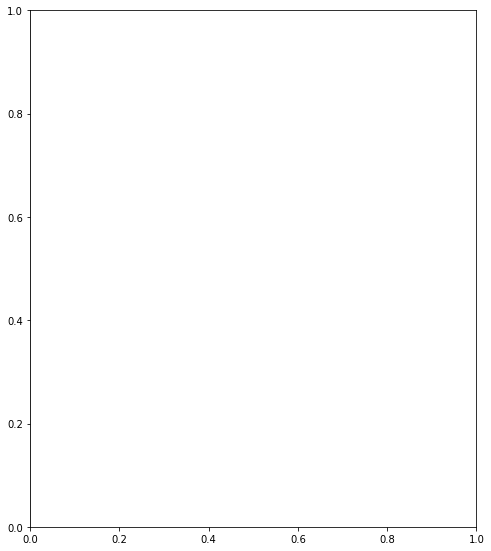

In [26]:
shap.summary_plot(test_numpy)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 2 with shape (20, 128, 3, 128, 3).

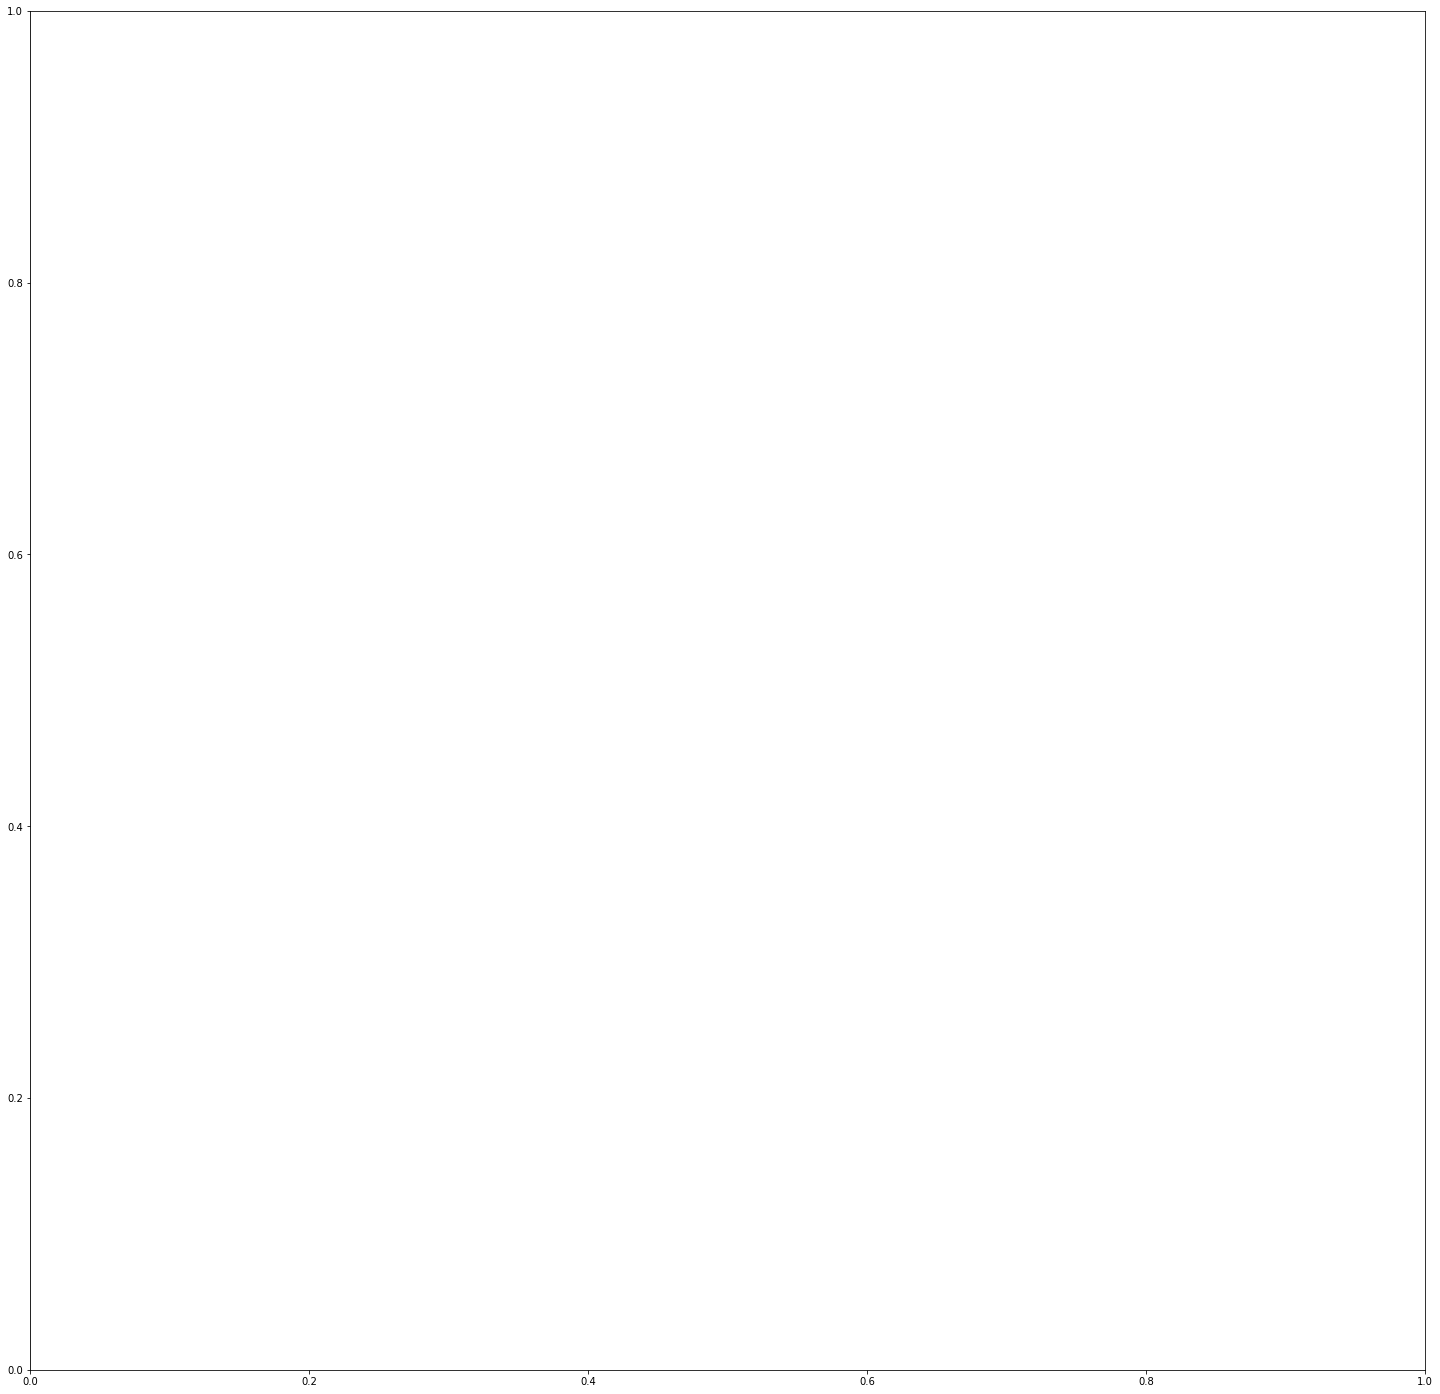

In [27]:
shap.summary_plot(shap_numpy, -test_numpy, plot_size=[25,25])